In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [2]:
train = pd.read_csv("/kaggle/input/vk-spam-ham/train_spam.csv")
unk_test = pd.read_csv("/kaggle/input/vk-spam-ham/test_spam.csv")

# Dataset review

In [3]:
train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [4]:
unk_test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [5]:
sum([1 if "," in words else 0 for text in train['text'] for words in text])

0

Text is given without comma punctuation. We dont want to remove other special symbols, which are present in the text, because such processing could decrease prediction quality in our particular problem.

Checking ratio of classes:

In [6]:
train['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

and maximum text length:

In [7]:
max(len(t) for t in train["text"])

800

In [8]:
max(len(t) for t in unk_test["text"])

800

In [9]:
train, val = train_test_split(train, test_size=0.2, stratify=train['text_type'])

# Simple naive bayes method

In [10]:
vectorizer = TfidfVectorizer()

X_train, y_train = train['text'], train['text_type'].apply(lambda x: 1 if x == 'spam' else 0)
X_val, y_val = val['text'], val['text_type'].apply(lambda x: 1 if x == 'spam' else 0)

X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

In [11]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

y_pred_nb = mnb.predict(X_val)
print("ROCAUC Score for Naive Bayes: ", roc_auc_score(y_pred_nb,y_val))
print(classification_report(y_pred_nb,y_val))

ROCAUC Score for Naive Bayes:  0.8948510910776867
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2698
           1       0.55      0.95      0.70       558

    accuracy                           0.86      3256
   macro avg       0.77      0.89      0.80      3256
weighted avg       0.91      0.86      0.87      3256



Very fast, good enough.

Lets try improving these results.

# SVM

In [12]:
svc = SVC()         
svc.fit(X_train, y_train)

y_pred_svm = svc.predict(X_val)
print("ROCAUC Score for SVC: ", roc_auc_score(y_pred_svm,y_val))
print(classification_report(y_pred_svm,y_val))

ROCAUC Score for SVC:  0.9461282019622557
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2366
           1       0.87      0.94      0.91       890

    accuracy                           0.95      3256
   macro avg       0.93      0.95      0.94      3256
weighted avg       0.95      0.95      0.95      3256



Slightly slower, but much better predictions.

# Random forest

In [13]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)

y_pred_rforest = rfc.predict(X_val)
print("ROCAUC Score for Random Forest Classifier : ", roc_auc_score(y_pred_rforest,y_val))
print(classification_report(y_pred_rforest,y_val))

ROCAUC Score for Random Forest Classifier :  0.9505943491650092
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2489
           1       0.78      0.98      0.87       767

    accuracy                           0.93      3256
   macro avg       0.89      0.95      0.91      3256
weighted avg       0.95      0.93      0.94      3256



Basically the same as SVC, though having better recall and rocauc.

I would personally use random forest, if neural network is too resource expensive.

# Bert classifier

Making dataset and dataloder classes for PyTorch train pipeline:

In [14]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.labels = dataframe['text_type'].apply(lambda x: 1 if x == 'spam' else 0).values
        self.messages = dataframe['text'].values
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        message = self.messages[idx]
        encoded = self.tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded['input_ids'].squeeze()
        attention_mask = encoded['attention_mask'].squeeze()
        return input_ids, attention_mask, label

def collate_fn(batch):
    input_ids, attention_masks, labels = zip(*batch)
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

In [15]:
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.messages = dataframe['text'].values
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.messages)
    
    def __getitem__(self, idx):
        message = self.messages[idx]
        encoded = self.tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded['input_ids'].squeeze()
        attention_mask = encoded['attention_mask'].squeeze()
        return input_ids, attention_mask

def collate_fnt(batch):
    input_ids, attention_masks = zip(*batch)
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    return input_ids, attention_masks

In [16]:
MODEL_NAME = "google-bert/bert-base-uncased"
EPOCHS=4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
batch_size=16

train_dataset = TextDataset(train, tokenizer=tokenizer)
val_dataset = TextDataset(val, tokenizer=tokenizer)
test_dataset = TestDataset(unk_test, tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fnt)

Making Bert Classifier from HF Bert:

In [18]:
class BertClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BertClassifier, self).__init__()
        self.model = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.model.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        logits = self.out(output)
        return logits

In [19]:
model = BertClassifier(n_classes=2).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [20]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss().to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    train_progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training")
    
    for batch in train_progress_bar:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask=attention_masks)
        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        
        train_progress_bar.set_postfix(loss=loss.item())
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    
    val_progress_bar = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Validation")
    
    with torch.no_grad():
        for batch in val_progress_bar:
            input_ids, attention_masks, labels = batch
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            
            logits = model(input_ids, attention_mask=attention_masks)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item()
            
            val_progress_bar.set_postfix(loss=loss.item(), accuracy=(val_accuracy / len(val_dataset)))
    
    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Training summary
print("Training Summary:")
for epoch, (train_loss, val_loss, val_accuracy) in enumerate(zip(train_losses, val_losses, val_accuracies)):
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch [1/4] Validation: 100%|██████████| 204/204 [01:05<00:00,  3.11it/s, accuracy=0.973, loss=0.0144]


Epoch [1/4], Train Loss: 0.1431, Val Loss: 0.0831, Val Accuracy: 0.9727


Epoch [2/4] Validation: 100%|██████████| 204/204 [01:05<00:00,  3.11it/s, accuracy=0.975, loss=0.0014]


Epoch [2/4], Train Loss: 0.0388, Val Loss: 0.0951, Val Accuracy: 0.9751


Epoch [3/4] Validation: 100%|██████████| 204/204 [01:05<00:00,  3.11it/s, accuracy=0.975, loss=0.000276]


Epoch [3/4], Train Loss: 0.0152, Val Loss: 0.1058, Val Accuracy: 0.9754


Epoch [4/4] Validation: 100%|██████████| 204/204 [01:05<00:00,  3.12it/s, accuracy=0.976, loss=0.000199]

Epoch [4/4], Train Loss: 0.0063, Val Loss: 0.1133, Val Accuracy: 0.9760
Training Summary:
Epoch [1/4], Train Loss: 0.1431, Val Loss: 0.0831, Val Accuracy: 0.9727
Epoch [2/4], Train Loss: 0.0388, Val Loss: 0.0951, Val Accuracy: 0.9751
Epoch [3/4], Train Loss: 0.0152, Val Loss: 0.1058, Val Accuracy: 0.9754
Epoch [4/4], Train Loss: 0.0063, Val Loss: 0.1133, Val Accuracy: 0.9760


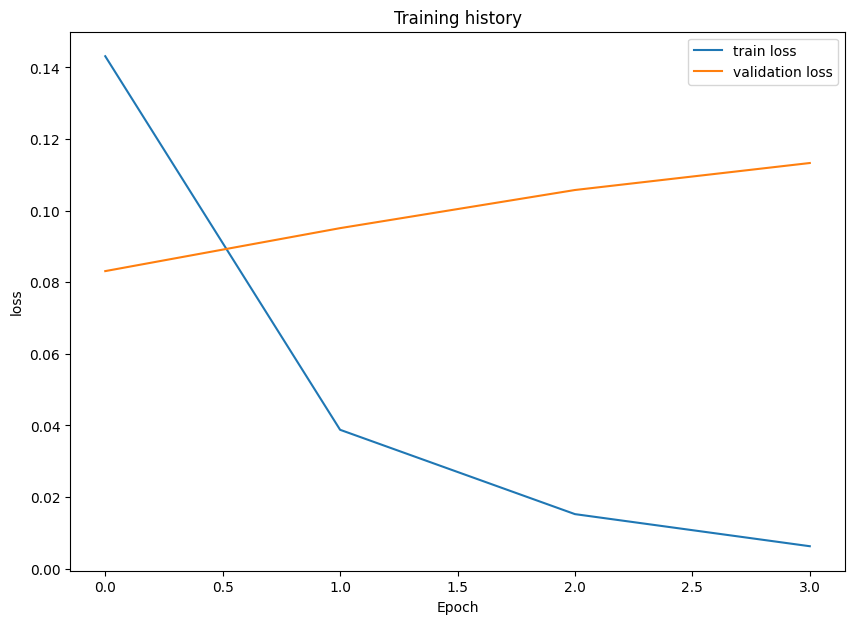

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
     

Calculating metrics on validation:

In [23]:
model.eval()

val_predictions = []
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_masks.to(device)
        logits = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(logits, dim=1).tolist()
        val_predictions.extend(batch_predictions)

In [24]:
roc_auc_score(val_dataset.labels, val_predictions)

0.9703239219368253

In [25]:
print(classification_report(val_dataset.labels, val_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2294
           1       0.96      0.96      0.96       962

    accuracy                           0.98      3256
   macro avg       0.97      0.97      0.97      3256
weighted avg       0.98      0.98      0.98      3256



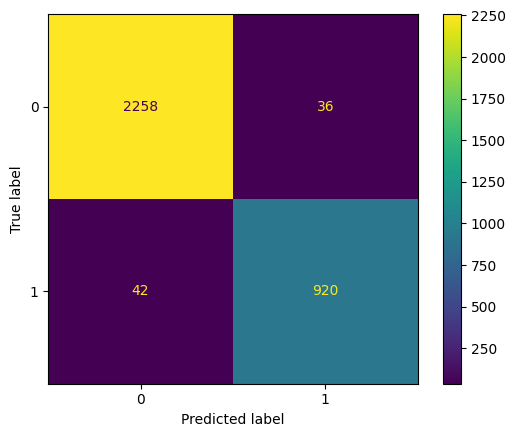

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix(val_dataset.labels, val_predictions))
disp.plot()

As we can see, Bert gives best results.

# Predictions on test

In [27]:
model.eval()

test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_masks = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_masks.to(device)
        logits = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(logits, dim=1).tolist()
        test_predictions.extend(batch_predictions)

In [28]:
unk_test['score'] = test_predictions

In [29]:
unk_test = unk_test[['score', 'text']]

In [30]:
unk_test.to_csv('test_preds_1_or_0.csv',index=False) # 1 is spam

In [31]:
unk_test_text = unk_test
unk_test_text['score'] = ['spam' if label == 1 else 'ham' for label in unk_test_text['score']]
unk_test_text.to_csv('test_preds_spam_or_ham.csv',index=False) 